In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

In [270]:
def GenerateLinearTrajectory(seqLen=252, stateDim=3, vel=None, start=None, dt=0.1):
    if start is None:
        start = torch.rand(stateDim) * 2 - 1
    if vel is None:
        vel = torch.rand(stateDim) * 2 - 1
    traj = []
    pos = start.clone()
    for _ in range(seqLen):
        traj.append(pos.clone())
        pos = pos + vel * dt
    traj = torch.stack(traj, dim=0)
    noise = torch.randn_like(traj) * 0.01
    traj = traj + noise
    return traj

In [271]:
"""
x = x1 + t * (x2 - x1)
y = y1 + t * (y2 - y1)
z = z1 + t * (z2 - z1)
"""

def MakeTrajectoryToSize(trajectory, reSize):
    # Add Extra points to trajectory by first select two random points in sequence
    # and then find the point at line created by two points
    seqTraj = []
    for row in trajectory:
        seqTraj.append(row)
    curShape = trajectory.shape
    numberOfPoints = reSize - curShape[0]
    for i in range(numberOfPoints):
        t = torch.randint(0, curShape[0] - 1, (1,)).item()
        newTensor = torch.tensor([(seqTraj[t][0] + seqTraj[t + 1][0])/2, seqTraj[t][1] + 0.5 * (seqTraj[t + 1][1] - seqTraj[t][1]), seqTraj[t][2] + 0.5 * (seqTraj[t + 1][2] - seqTraj[t][2]), seqTraj[t][3] + 0.5 * (seqTraj[t + 1][3] - seqTraj[t][3])])
        seqTraj.insert(t + 1, newTensor)
    return torch.stack(seqTraj, dim=0)


In [272]:
a = torch.rand(300, 4)
MakeTrajectoryToSize(a, 252).shape

torch.Size([300, 4])

In [294]:
class DataSet:
    def __init__(self):
        self.trajectory = [GenerateLinearTrajectory() for _ in range(5000)]

    def Show(self, index, giveTraj=None):
        if giveTraj is None:
            trajToPlot = self.trajectory[index]
        else:
            trajToPlot = giveTraj
        
        x = trajToPlot[:, 0]
        y = trajToPlot[:, 1]
        z = trajToPlot[:, 2]
        
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(x.numpy(), y.numpy(), z.numpy(), marker="o", markersize=2, color="blue", label="Trajectory")
        ax.scatter(x[0], y[0], z[0], color="green", s=80, label="Start")
        ax.scatter(x[-1], y[-1], z[-1], color="red", s=80, label="Goal")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title("Drone Trajectory in 3D")
        ax.legend()
        plt.show()

In [295]:
# class DataSet:
#     def __init__(self):
#         path = r"/home/shivam/project/code/Synthetic-UAV-Flight-Trajectories"
#         dir_list = os.listdir(path)
#         temp_trajectories = []
#         for fileName in dir_list:
#             try:
#                 filePath = os.path.join(path, fileName)
#                 data = pd.read_csv(filePath)
#                 traj_tensor = MakeTrajectoryToSize(torch.from_numpy(data.to_numpy()), 252)[:, 1:]
#                 temp_trajectories.append(traj_tensor)
#             except Exception as e:
#                 print(f"Skipping file {fileName} due to error: {e}")
#                 continue
#         allPoints = torch.cat(temp_trajectories, dim=0).float()
#         self.minVals = torch.min(allPoints, dim=0).values
#         self.maxVals = torch.max(allPoints, dim=0).values
#         self.trajectory = []
#         for traj in temp_trajectories:
#             self.trajectory.append(self.normalize(traj.float()))

#     def normalize(self, trajectory):
#         epsilon = 1e-8
#         return 2 * (trajectory - self.minVals) / (self.maxVals - self.minVals + epsilon) - 1

#     def denormalize(self, trajectory):
#         epsilon = 1e-8
#         return (trajectory + 1) * (self.maxVals - self.minVals + epsilon) / 2 + self.minVals

#     def Show(self, index, giveTraj=None):
#         if giveTraj is None:
#             trajToPlot = self.trajectory[index]
#         else:
#             trajToPlot = giveTraj
#         denormalizedTraj = self.denormalize(trajToPlot.cpu())
        
#         x = denormalizedTraj[:, 0]
#         y = denormalizedTraj[:, 1]
#         z = denormalizedTraj[:, 2]
        
#         fig = plt.figure(figsize=(8,6))
#         ax = fig.add_subplot(111, projection="3d")
#         ax.plot(x.numpy(), y.numpy(), z.numpy(), marker="o", markersize=2, color="blue", label="Trajectory")
#         ax.scatter(x[0], y[0], z[0], color="green", s=80, label="Start")
#         ax.scatter(x[-1], y[-1], z[-1], color="red", s=80, label="Goal")
#         ax.set_xlabel("X")
#         ax.set_ylabel("Y")
#         ax.set_zlabel("Z")
#         ax.set_title("Drone Trajectory in 3D")
#         ax.legend()
#         plt.show()

In [296]:
def SinusoidalTimeEmbedding(timesteps, dim):
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(-torch.arange(0, half, dtype=torch.float32, device=device) * (torch.log(torch.tensor(10000.0)) / (half - 1)))
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros((emb.shape[0],1), device=device)], dim=1)
    return emb

In [ ]:
class UNet(nn.Module):
    def __init__(self, stateDim, hiddenDim=128, seqLen=252):
        super().__init__()
        self.conv1 = nn.Conv1d(stateDim, hiddenDim, 3, padding=1)
        self.conv2 = nn.Conv1d(hiddenDim, hiddenDim * 2, 3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(hiddenDim * 2, hiddenDim * 4, 3, stride=2, padding=1)
        self.convMid = nn.Conv1d(hiddenDim * 4, hiddenDim * 4, 3, padding=1)
        self.deconv1 = nn.ConvTranspose1d(hiddenDim * 4, hiddenDim * 2, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose1d(hiddenDim * 2, hiddenDim, 4, stride=2, padding=1)
        self.convOut = nn.Conv1d(hiddenDim, stateDim, 3, padding=1)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.timeEmbd = nn.Sequential(
            nn.Linear(hiddenDim * 2, hiddenDim*4),
            nn.SiLU(),
            nn.Linear(hiddenDim*4, hiddenDim*4)
        )

    def forward(self, x, t):
        x = x.permute(0, 2, 1)
        e1 = F.relu(self.conv1(x))
        e2 = F.relu(self.conv2(e1))
        e3 = F.relu(self.conv3(e2))

        tEmbd = SinusoidalTimeEmbedding(t, self.timeEmbd[0].in_features)
        tFeat = self.timeEmbd(tEmbd).unsqueeze(-1)
        e3 = e3 + tFeat

        b = F.relu(self.convMid(e3))
        d1 = F.relu(self.deconv1(b))
        d2 = F.relu(self.deconv2(d1 + e2))
        out = self.convOut(d2 + e1)
        
        return out.permute(0, 2, 1)

In [349]:
class Diffusion:
    def __init__(self):
        self.dataset = DataSet()
        self.T = 1000
        self.alphaBar,self.beta = self.CreateAlpha()

    def CreateAlpha(self):
        beta = torch.linspace(1e-4, 0.02, self.T)
        alpha = 1 - beta
        return torch.cumprod(alpha, dim=0),beta

    def ForwardDiffusion(self, x0, t): 
        alpha = self.alphaBar[t].view(x0.shape[0], 1, 1)
        eps = torch.randn_like(x0)
        return torch.sqrt(alpha) * x0 + torch.sqrt(1 - alpha) * eps, eps

def ReverseDiffusionModel(model, df, start, end):
    tau = torch.rand(1, 252, 3).to(model.device)
    for i in range(900, 0, -1):
        # tau[0, 0] = start
        # tau[0, -1] = end
        t = torch.full((1,), i, dtype=torch.long, device=model.device)        
        eps = model(tau, t)
        alphaBarT = df.alphaBar[i]
        betaT = df.beta[i]
        alphaT = 1 - betaT
        mean = (1 / torch.sqrt(alphaT)) * (tau - ((1 - alphaT) / torch.sqrt(1 - alphaBarT)) * eps)
        noise = torch.randn_like(tau)
        if(i > 0):
            tau = mean + torch.sqrt(betaT) * noise
        else:
            tau = mean
        
    # tau[0, 0] = start
    # tau[0, -1] = end
    return tau

In [299]:
class Train:
    def __init__(self):
        self.df = Diffusion()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.unet = UNet(stateDim=3).to(self.device)
        self.batchSize = 64
        self.lossFn = nn.MSELoss()
        self.optim = torch.optim.Adam(self.unet.parameters(), lr=1e-3)

    def Train(self, epoch = 1000):
        
        for epc in range(epoch):
            totalLoss = 0
            for index in range(self.batchSize, len(self.df.dataset.trajectory), self.batchSize):
                xT = torch.stack(self.df.dataset.trajectory[index - self.batchSize: index])
                t = torch.randint(0, self.df.T, (xT.shape[0],))
                noisyTraj ,noiseps = self.df.ForwardDiffusion(xT, t)
                input = noisyTraj.to(self.device).float()
                target = noiseps.to(self.device).float()
                t = t.to(self.device)

                output = self.unet(input, t)
                loss = self.lossFn(output, target)
                self.optim.zero_grad()
                loss.backward()
                totalLoss += loss.item()
                self.optim.step()
            print(f"Epoch : {epc}/{epoch} | Loss: {totalLoss}")

In [300]:
tr = Train()

In [301]:
tr.Train(epoch=2000)

Epoch : 0/2000 | Loss: 40.85800491273403
Epoch : 1/2000 | Loss: 15.054472863674164
Epoch : 2/2000 | Loss: 10.913245856761932
Epoch : 3/2000 | Loss: 9.121552005410194
Epoch : 4/2000 | Loss: 8.092504493892193
Epoch : 5/2000 | Loss: 7.791271135210991
Epoch : 6/2000 | Loss: 7.0852344036102295
Epoch : 7/2000 | Loss: 6.573557935655117
Epoch : 8/2000 | Loss: 6.159809861332178
Epoch : 9/2000 | Loss: 5.709560304880142
Epoch : 10/2000 | Loss: 5.663331642746925
Epoch : 11/2000 | Loss: 5.786567777395248
Epoch : 12/2000 | Loss: 5.435947265475988
Epoch : 13/2000 | Loss: 4.896396044641733
Epoch : 14/2000 | Loss: 5.3285488821566105
Epoch : 15/2000 | Loss: 4.795128777623177
Epoch : 16/2000 | Loss: 4.924070551991463
Epoch : 17/2000 | Loss: 4.9217006377875805
Epoch : 18/2000 | Loss: 4.407642260193825
Epoch : 19/2000 | Loss: 4.353013284504414
Epoch : 20/2000 | Loss: 4.524117134511471
Epoch : 21/2000 | Loss: 4.507804799824953
Epoch : 22/2000 | Loss: 4.380092702805996
Epoch : 23/2000 | Loss: 4.3455234169960

In [ ]:
# torch.save(tr.unet.state_dict(), "test2.pth")

In [343]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(stateDim=3).to(device)
model.load_state_dict(torch.load("test.pth", map_location=device))
model.eval()

UNet(
  (conv1): Conv1d(3, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (convMid): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv1): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(2,), padding=(1,))
  (deconv2): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (convOut): Conv1d(128, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (timeEmbd): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
)

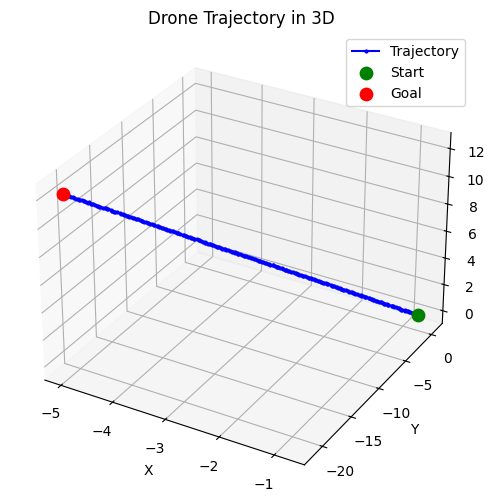

In [335]:
tr.df.dataset.trajectory[0].shape
tr.df.dataset.Show(1, tr.df.dataset.trajectory[10])

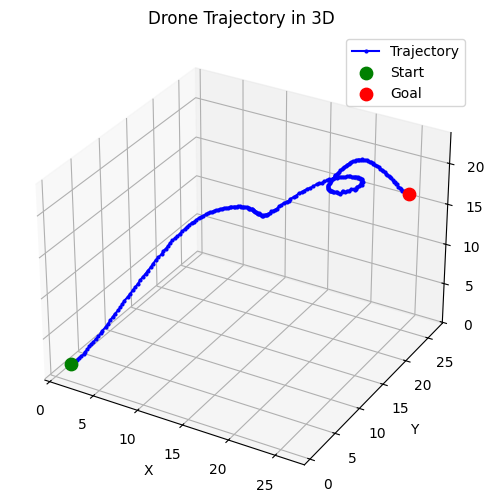

In [ ]:
T = tr.df.alphaBar
traj = ReverseDiffusionModel(model, tr.df, start=tr.df.dataset.trajectory[10][0], end=tr.df.dataset.trajectory[10][-1]).squeeze(0).cpu().detach()
tr.df.dataset.Show(1, traj)